In [1]:
"""
Part 1: Feature Extraction Pipeline
Extracts 2048-dimensional feature vectors from images using pre-trained ResNet50
Run this ONCE on Kaggle to generate flickr30k_features.pkl
"""

import os
import pickle
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm


def find_image_dir():
    """Find the Flickr30k image directory"""
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None


IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"✓ Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory.")


# --- DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


# --- FEATURE EXTRACTION PIPELINE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {device}")

# Load pre-trained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
model = nn.DataParallel(model).to(device)
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load dataset
dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)

print(f"Total images to process: {len(dataset)}")

# Extract features
features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

# Save features
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"\n✓ Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

✓ Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
✓ Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Total images to process: 31783


Extracting Features: 100%|██████████| 249/249 [01:47<00:00,  2.31it/s]



✓ Success! 31783 images processed and saved to flickr30k_features.pkl


In [2]:
"""
SIMPLE TEXT PREPROCESSING - Flickr30k Captions
Combines best features: auto file discovery + image-caption mapping + validation
"""

import os
import re
import pickle
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple

# ============================================================================
# MAIN CLASS - Simple & Clean
# ============================================================================

class SimplePreprocessor:
    """One-class solution for caption preprocessing"""
    
    CONTRACTIONS = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot",
        "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "isn't": "is not", "it's": "it is", "that's": "that is",
        "won't": "will not", "wouldn't": "would not", "you're": "you are",
    }
    
    def __init__(self):
        self.captions_file = self._find_captions_file()
    
    def _find_captions_file(self):
        """Auto-discover captions.txt file"""
        search_paths = ['/kaggle/input', './data', '../data', '.']
        
        for path in search_paths:
            if os.path.exists(path):
                for root, dirs, files in os.walk(path):
                    for file in files:
                        if 'caption' in file.lower() and file.endswith('.txt'):
                            return os.path.join(root, file)
        
        raise FileNotFoundError("Cannot find captions.txt. Check /kaggle/input or ./data")
    
    def preprocess(self, caption: str) -> str:
        """Clean a single caption"""
        caption = caption.lower()
        
        # Expand contractions
        for contraction, expansion in self.CONTRACTIONS.items():
            caption = caption.replace(contraction, expansion)
        
        # Remove URLs
        caption = re.sub(r'http\S+|www\S+', '', caption)
        
        # Remove punctuation
        caption = re.sub(r'[^\w\s]', '', caption)
        
        # Clean spaces
        caption = ' '.join(caption.split())
        
        # Add tokens
        caption = '<start> ' + caption + ' <end>'
        
        return caption
    
    def run(self):
        """Main pipeline"""
        print("\n" + "="*60)
        print("PREPROCESSING FLICKR30K CAPTIONS")
        print("="*60)
        
        # Load captions
        print("\n[1] Loading captions...")
        df = pd.read_csv(self.captions_file)
        df.columns = df.columns.str.strip()
        
        # Find columns
        image_col = next((c for c in df.columns if 'image' in c.lower()), df.columns[0])
        caption_col = next((c for c in df.columns if 'caption' in c.lower()), df.columns[1])
        
        # Create image->captions mapping
        image_to_captions = defaultdict(list)
        for _, row in df.iterrows():
            img = str(row[image_col]).strip()
            cap = str(row[caption_col]).strip()
            image_to_captions[img].append(cap)
        
        print(f"✓ Loaded {len(image_to_captions)} images, {len(df)} captions")
        
        # Preprocess all captions
        print("\n[2] Preprocessing...")
        image_to_processed = {}
        for img, caps in image_to_captions.items():
            image_to_processed[img] = [self.preprocess(c) for c in caps]
        
        print(f"✓ Processed {len(df)} captions")
        
        # Show examples
        print("\n[3] Examples:")
        for img, caps in list(image_to_processed.items())[:2]:
            print(f"\n  Image: {img}")
            for cap in caps[:2]:
                print(f"    - {cap}")
        
        # Compute stats
        print("\n[4] Statistics:")
        original_lengths = [len(c.split()) for caps in image_to_captions.values() for c in caps]
        processed_lengths = [len(c.split()) for caps in image_to_processed.values() for c in caps]
        
        print(f"  Original avg length: {np.mean(original_lengths):.2f} words")
        print(f"  Processed avg length: {np.mean(processed_lengths):.2f} words")
        
        # Save results
        print("\n[5] Saving...")
        
        # Pickle
        pickle.dump({
            'image_to_captions': dict(image_to_captions),
            'image_to_processed': image_to_processed,
        }, open('captions.pkl', 'wb'))
        print("  ✓ captions.pkl (for training)")
        
        # JSON stats
        json.dump({
            'total_images': len(image_to_processed),
            'total_captions': len(df),
            'avg_original_length': float(np.mean(original_lengths)),
            'avg_processed_length': float(np.mean(processed_lengths)),
        }, open('stats.json', 'w'), indent=2)
        print("  ✓ stats.json (statistics)")
        
        print("\n" + "="*60)
        print("✓ DONE! Ready to train.")
        print("="*60)
        
        return image_to_processed


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    preprocessor = SimplePreprocessor()
    image_to_processed = preprocessor.run()
    
    # Quick example: use in training
    # for image_name, captions in image_to_processed.items():
    #     image = load_image(image_name)
    #     for caption in captions:
    #         train_model(image, caption)


PREPROCESSING FLICKR30K CAPTIONS

[1] Loading captions...
✓ Loaded 31783 images, 158915 captions

[2] Preprocessing...
✓ Processed 158915 captions

[3] Examples:

  Image: 1000092795.jpg
    - <start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>
    - <start> two young white males are outside near many bushes <end>

  Image: 10002456.jpg
    - <start> several men in hard hats are operating a giant pulley system <end>
    - <start> workers look down from up above on a piece of equipment <end>

[4] Statistics:
  Original avg length: 13.39 words
  Processed avg length: 14.26 words

[5] Saving...
  ✓ captions.pkl (for training)
  ✓ stats.json (statistics)

✓ DONE! Ready to train.


In [3]:
"""
VOCABULARY + DATASET - SHORT & SIMPLE
Builds vocab and creates PyTorch DataLoaders
"""

import os
import pickle
import random
import torch
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


class Vocabulary:
    """Simple vocabulary builder"""
    
    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.word_freq = Counter()
    
    def build_vocabulary(self, captions_list):
        """Build vocabulary from captions"""
        # Count word frequencies
        for caption in captions_list:
            self.word_freq.update(caption.split())
        
        # Add words that meet threshold
        idx = 4
        for word, freq in self.word_freq.most_common():
            if freq >= self.freq_threshold and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
        
        print(f"✓ Vocabulary: {len(self.word2idx)} tokens")
    
    def encode(self, caption, add_tokens=True):
        """Convert caption to indices"""
        tokens = []
        if add_tokens:
            tokens.append(self.word2idx['<start>'])
        
        for word in caption.split():
            tokens.append(self.word2idx.get(word, self.word2idx['<unk>']))
        
        if add_tokens:
            tokens.append(self.word2idx['<end>'])
        
        return tokens
    
    def __len__(self):
        return len(self.word2idx)


class CaptionDataset(Dataset):
    """PyTorch Dataset for image-caption pairs"""
    
    def __init__(self, image_names, image_to_captions, vocab):
        self.data = []
        self.vocab = vocab
        
        for img_name in image_names:
            if img_name in image_to_captions:
                for caption in image_to_captions[img_name]:
                    self.data.append((img_name, caption))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name, caption = self.data[idx]
        caption_indices = self.vocab.encode(caption)
        return img_name, torch.LongTensor(caption_indices)


def collate_fn(batch):
    """Handle variable-length captions"""
    image_names, captions = zip(*batch)
    
    # Get lengths and sort by length
    lengths = [len(cap) for cap in captions]
    sorted_indices = sorted(range(len(lengths)), key=lambda i: lengths[i], reverse=True)
    
    # Reorder
    image_names = [image_names[i] for i in sorted_indices]
    captions = [captions[i] for i in sorted_indices]
    lengths = sorted(lengths, reverse=True)
    
    # Pad captions
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=0)
    
    return image_names, captions_padded, torch.LongTensor(lengths)


def main():
    print("\n" + "="*60)
    print("VOCABULARY + DATASET BUILDER")
    print("="*60)
    
    # Load preprocessed captions
    print("\n[1] Loading captions...")
    data = pickle.load(open('captions.pkl', 'rb'))
    image_to_captions = data['image_to_processed']
    print(f"✓ {len(image_to_captions)} images loaded")
    
    # Build vocabulary
    print("\n[2] Building vocabulary...")
    all_captions = [cap for caps in image_to_captions.values() for cap in caps]
    vocab = Vocabulary(freq_threshold=5)
    vocab.build_vocabulary(all_captions)
    
    # Create train/val/test split
    print("\n[3] Splitting data...")
    all_images = list(image_to_captions.keys())
    random.shuffle(all_images)
    
    train_size = int(0.8 * len(all_images))
    val_size = int(0.1 * len(all_images))
    
    train_images = all_images[:train_size]
    val_images = all_images[train_size:train_size + val_size]
    test_images = all_images[train_size + val_size:]
    
    print(f"  Train: {len(train_images)} images")
    print(f"  Val: {len(val_images)} images")
    print(f"  Test: {len(test_images)} images")
    
    # Create datasets
    print("\n[4] Creating datasets...")
    train_dataset = CaptionDataset(train_images, image_to_captions, vocab)
    val_dataset = CaptionDataset(val_images, image_to_captions, vocab)
    test_dataset = CaptionDataset(test_images, image_to_captions, vocab)
    
    # Create dataloaders
    print("\n[5] Creating dataloaders...")
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")
    
    # Test dataloader
    print("\n[6] Testing dataloader...")
    batch = next(iter(train_loader))
    image_names, captions, lengths = batch
    print(f"  Batch size: {len(image_names)}")
    print(f"  Captions shape: {captions.shape}")
    print(f"  Lengths: {lengths[:3]}")
    
    # Save
    print("\n[7] Saving...")
    pickle.dump(vocab.__dict__, open('vocab.pkl', 'wb'))
    torch.save({
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'vocab': vocab,
    }, 'dataloaders.pt')
    print("✓ Saved: vocab.pkl, dataloaders.pt")
    
    print("\n" + "="*60)
    print("✓ DONE! Ready to train")
    print("="*60)


if __name__ == "__main__":
    main()


VOCABULARY + DATASET BUILDER

[1] Loading captions...
✓ 31783 images loaded

[2] Building vocabulary...
✓ Vocabulary: 7727 tokens

[3] Splitting data...
  Train: 25426 images
  Val: 3178 images
  Test: 3179 images

[4] Creating datasets...

[5] Creating dataloaders...
  Train batches: 3973
  Val batches: 497
  Test batches: 497

[6] Testing dataloader...
  Batch size: 32
  Captions shape: torch.Size([32, 24])
  Lengths: tensor([24, 23, 22])

[7] Saving...
✓ Saved: vocab.pkl, dataloaders.pt

✓ DONE! Ready to train


In [4]:
"""
ENCODER-DECODER WITH ATTENTION - SHORT & CORRECT
Image captioning model: Encoder (image) + Decoder (caption) with Bahdanau Attention
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class Encoder(nn.Module):
    """Project image features (16 regions × 2048) to hidden_size"""
    
    def __init__(self, feature_size=2048, hidden_size=512, dropout=0.5):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, features):
        """
        Args:
            features: (batch_size, num_regions=16, 2048)
        Returns:
            encoded: (batch_size, num_regions, hidden_size)
        """
        x = self.fc(features)
        x = self.layer_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x


class BahdanauAttention(nn.Module):
    """Bahdanau attention - lets decoder focus on different image regions"""
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_encoder = nn.Linear(encoder_dim, attention_dim)
        self.W_decoder = nn.Linear(decoder_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1)
    
    def forward(self, encoder_out, decoder_hidden, encoder_proj=None):
        """
        Args:
            encoder_out:    (batch, num_regions, encoder_dim)
            decoder_hidden: (batch, decoder_dim)
            encoder_proj:   (batch, num_regions, attention_dim) - pre-computed
        Returns:
            context: (batch, encoder_dim)
            alpha:   (batch, num_regions)
        """
        if encoder_proj is None:
            encoder_proj = self.W_encoder(encoder_out)
        
        decoder_proj = self.W_decoder(decoder_hidden).unsqueeze(1)  # (batch, 1, att_dim)
        scores = self.V(torch.tanh(encoder_proj + decoder_proj)).squeeze(2)  # (batch, regions)
        alpha = F.softmax(scores, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch, encoder_dim)
        
        return context, alpha


class Decoder(nn.Module):
    """LSTM decoder with Bahdanau attention for caption generation"""
    
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, 
                 num_layers=2, dropout=0.5):
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Attention
        self.attention = BahdanauAttention(hidden_size, hidden_size, hidden_size)
        
        # Embedding
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        # LSTM: input = [word_embedding; context]
        self.lstm = nn.LSTM(embed_size + hidden_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Output: [lstm_hidden; context] → vocab
        self.fc = nn.Linear(hidden_size + hidden_size, vocab_size)
        
        # Context gating
        self.gate = nn.Linear(hidden_size, hidden_size)
        
        # Initialize hidden state from encoder
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
    
    def _init_hidden(self, encoder_out):
        """Initialize LSTM hidden state from mean-pooled encoder features"""
        mean = encoder_out.mean(dim=1)  # (batch, hidden)
        h0 = torch.tanh(self.init_h(mean)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.tanh(self.init_c(mean)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h0, c0
    
    def forward(self, encoder_out, captions, lengths):
        """
        Training forward pass with attention at every timestep.
        
        Args:
            encoder_out: (batch, num_regions, hidden_size)
            captions:    (batch, max_len)
            lengths:     (batch,) actual caption lengths
        Returns:
            outputs: (batch, max_len-1, vocab_size)
        """
        batch_size = encoder_out.size(0)
        max_len = captions.size(1) - 1
        
        # Embed captions (exclude last token for teacher forcing)
        embeddings = self.embedding(captions[:, :-1])  # (batch, T, embed)
        embeddings = self.dropout(embeddings)
        
        # Initialize LSTM hidden state
        h, c = self._init_hidden(encoder_out)
        
        # Pre-compute encoder projection (optimization)
        encoder_proj = self.attention.W_encoder(encoder_out)
        
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_out.device)
        
        # Decode step by step
        for t in range(max_len):
            # Attention: which image regions matter?
            context, alpha = self.attention(encoder_out, h[-1], encoder_proj)
            
            # Gate the context
            gate = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate * context
            
            # LSTM: [word_embedding; gated_context]
            lstm_input = torch.cat([embeddings[:, t, :], gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            
            # Output: [hidden; context] → vocab
            output = self.fc(self.dropout(torch.cat([lstm_out.squeeze(1), context], dim=1)))
            outputs[:, t, :] = output
        
        return outputs
    
    def sample(self, encoder_out, max_len=20, start_token=1, end_token=2):
        """Generate caption using greedy search"""
        batch_size = encoder_out.size(0)
        sampled_ids = []
        
        h, c = self._init_hidden(encoder_out)
        encoder_proj = self.attention.W_encoder(encoder_out)
        
        inputs = torch.LongTensor([start_token] * batch_size).unsqueeze(1).to(encoder_out.device)
        
        for i in range(max_len):
            embeddings = self.embedding(inputs).squeeze(1)  # (batch, embed)
            
            context, alpha = self.attention(encoder_out, h[-1], encoder_proj)
            gate = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate * context
            
            lstm_input = torch.cat([embeddings, gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            
            outputs = self.fc(torch.cat([lstm_out.squeeze(1), context], dim=1))
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted)
            inputs = predicted.unsqueeze(1)
        
        return torch.stack(sampled_ids, 1)


# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize models
    HIDDEN_SIZE = 512
    EMBED_SIZE = 256
    NUM_LAYERS = 2
    DROPOUT = 0.5
    VOCAB_SIZE = 10000
    
    encoder = Encoder(feature_size=2048, hidden_size=HIDDEN_SIZE, dropout=DROPOUT).to(device)
    decoder = Decoder(vocab_size=VOCAB_SIZE, embed_size=EMBED_SIZE, 
                     hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)
    
    print("Model Architecture:")
    print(f"Encoder: Image (16×2048) → Hidden (16×{HIDDEN_SIZE})")
    print(f"Decoder: Caption + Attention → Logits")
    
    # Count parameters
    encoder_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
    decoder_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
    
    print(f"\nParameters:")
    print(f"  Encoder: {encoder_params:,}")
    print(f"  Decoder: {decoder_params:,}")
    print(f"  Total: {encoder_params + decoder_params:,}")
    
    # Test
    print("\nTesting...")
    batch_size = 4
    num_regions = 16
    max_len = 20
    
    image_features = torch.randn(batch_size, num_regions, 2048).to(device)
    captions = torch.randint(0, VOCAB_SIZE, (batch_size, max_len)).to(device)
    lengths = torch.tensor([max_len] * batch_size).to(device)
    
    # Forward
    encoder_out = encoder(image_features)
    outputs = decoder(encoder_out, captions, lengths)
    
    print(f"✓ Input: {image_features.shape} → Output: {outputs.shape}")
    print(f"✓ Expected: torch.Size([{batch_size}, {max_len-1}, {VOCAB_SIZE}])")
    print("✓ Model works correctly!")

Model Architecture:
Encoder: Image (16×2048) → Hidden (16×512)
Decoder: Caption + Attention → Logits

Parameters:
  Encoder: 1,050,112
  Decoder: 18,850,577
  Total: 19,900,689

Testing...
✓ Input: torch.Size([4, 16, 2048]) → Output: torch.Size([4, 19, 10000])
✓ Expected: torch.Size([4, 19, 10000])
✓ Model works correctly!


In [30]:
"""
COMPLETE TRAINING PIPELINE - With Real Image Features
Preprocessing → Vocab → Train → Inference
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import json
import pickle
import random
import numpy as np

BATCH_SIZE = 128
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================================
# MODELS
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, feature_size=2048, hidden_size=512, dropout=0.5):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, features):
        x = self.fc(features)
        x = self.layer_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x


class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_encoder = nn.Linear(encoder_dim, attention_dim)
        self.W_decoder = nn.Linear(decoder_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1)
    
    def forward(self, encoder_out, decoder_hidden, encoder_proj=None):
        if encoder_proj is None:
            encoder_proj = self.W_encoder(encoder_out)
        decoder_proj = self.W_decoder(decoder_hidden).unsqueeze(1)
        scores = self.V(torch.tanh(encoder_proj + decoder_proj)).squeeze(2)
        alpha = F.softmax(scores, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.attention = BahdanauAttention(hidden_size, hidden_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + hidden_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size + hidden_size, vocab_size)
        self.gate = nn.Linear(hidden_size, hidden_size)
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.num_layers = num_layers
    
    def _init_hidden(self, encoder_out):
        h0 = torch.tanh(self.init_h(encoder_out)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.tanh(self.init_c(encoder_out)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h0, c0
    
    def forward(self, encoder_out, captions, lengths):
        batch_size = encoder_out.size(0)
        max_len = captions.size(1) - 1
        embeddings = self.embedding(captions[:, :-1])
        embeddings = self.dropout(embeddings)
        h, c = self._init_hidden(encoder_out)
        
        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)
        
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_out.device)
        for t in range(max_len):
            context, alpha = self.attention(encoder_out_expanded, h[-1], encoder_proj)
            gate = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate * context
            lstm_input = torch.cat([embeddings[:, t, :], gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(torch.cat([lstm_out.squeeze(1), context], dim=1)))
            outputs[:, t, :] = output
        return outputs
    
    def sample(self, encoder_out, max_len=20):
        """Greedy decoding for inference"""
        batch_size = encoder_out.size(0)
        sampled_ids = []
        
        h, c = self._init_hidden(encoder_out)
        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)
        
        current_input = torch.ones(batch_size, dtype=torch.long).to(encoder_out.device)
        
        for t in range(max_len):
            embeddings = self.embedding(current_input)
            context, alpha = self.attention(encoder_out_expanded, h[-1], encoder_proj)
            gate = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate * context
            lstm_input = torch.cat([embeddings, gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(torch.cat([lstm_out.squeeze(1), context], dim=1)))
            predicted = output.argmax(1)
            sampled_ids.append(predicted.cpu().numpy())
            current_input = predicted
        
        return np.column_stack(sampled_ids)


# ============================================================================
# DATASET
# ============================================================================

class ImageCaptionDataset(Dataset):
    def __init__(self, image_names, features_dict, image_to_captions, vocab):
        self.image_names = image_names
        self.features_dict = features_dict
        self.image_to_captions = image_to_captions
        self.vocab = vocab
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        captions = self.image_to_captions[img_name]
        
        # Pick random caption
        caption = random.choice(captions)
        
        # Encode caption
        tokens = [self.vocab.word2idx.get('<start>', 1)]
        for word in caption.split():
            tokens.append(self.vocab.word2idx.get(word, self.vocab.word2idx.get('<unk>', 3)))
        tokens.append(self.vocab.word2idx.get('<end>', 2))
        
        # Get features
        features = torch.FloatTensor(self.features_dict[img_name])
        
        return torch.LongTensor(tokens), features


def collate_fn(batch):
    """Pad captions and stack features"""
    captions, features = zip(*batch)
    
    # Pad captions
    max_len = max(len(c) for c in captions)
    padded_captions = []
    for cap in captions:
        if len(cap) < max_len:
            padding = torch.zeros(max_len - len(cap), dtype=cap.dtype)
            padded_cap = torch.cat([cap, padding])
        else:
            padded_cap = cap
        padded_captions.append(padded_cap)
    
    captions = torch.stack(padded_captions)
    features = torch.stack(features)
    
    return captions, features


# ============================================================================
# TRAINING
# ============================================================================

def train_epoch(encoder, decoder, train_loader, criterion, optimizer, device, word2idx):
    encoder.train()
    decoder.train()
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    progress_bar = tqdm(train_loader, desc="Training")
    
    for captions, features in progress_bar:
        captions = captions.to(device)
        features = features.to(device)
        
        # ✅ USE REAL FEATURES
        encoded = encoder(features)
        outputs = decoder(encoded, captions, None)
        
        outputs_flat = outputs.reshape(-1, outputs.shape[2])
        targets = captions[:, 1:]
        targets_flat = targets.reshape(-1)
        
        loss = criterion(outputs_flat, targets_flat)
        
        predictions = outputs_flat.argmax(dim=1)
        non_pad_mask = targets_flat != 0
        correct = (predictions == targets_flat) & non_pad_mask
        total_correct += correct.sum().item()
        total_tokens += non_pad_mask.sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(encoder.parameters()) + list(decoder.parameters()), max_norm=5.0
        )
        optimizer.step()
        
        total_loss += loss.item()
        batch_acc = correct.sum().item() / max(non_pad_mask.sum().item(), 1) * 100
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{batch_acc:.1f}%'})
    
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_correct / max(total_tokens, 1) * 100
    return avg_loss, avg_acc


def validate(encoder, decoder, val_loader, criterion, device, word2idx):
    encoder.eval()
    decoder.eval()
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for captions, features in tqdm(val_loader, desc="Validation"):
            captions = captions.to(device)
            features = features.to(device)
            
            # ✅ USE REAL FEATURES
            encoded = encoder(features)
            outputs = decoder(encoded, captions, None)
            
            outputs_flat = outputs.reshape(-1, outputs.shape[2])
            targets = captions[:, 1:]
            targets_flat = targets.reshape(-1)
            
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()
            
            predictions = outputs_flat.argmax(dim=1)
            non_pad_mask = targets_flat != 0
            correct = (predictions == targets_flat) & non_pad_mask
            total_correct += correct.sum().item()
            total_tokens += non_pad_mask.sum().item()
    
    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / max(total_tokens, 1) * 100
    return avg_loss, avg_acc


# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("TRAINING WITH REAL IMAGE FEATURES")
    print("="*70)
    
    # Load vocabulary
    print("\n[1] Loading vocabulary...")
    vocab_data = pickle.load(open('vocab.pkl', 'rb'))
    
    class Vocab:
        pass
    vocab = Vocab()
    vocab.word2idx = vocab_data['word2idx']
    vocab.idx2word = vocab_data['idx2word']
    vocab_size = len(vocab_data['word2idx'])
    print(f"✓ Vocab size: {vocab_size}")
    
    # Load captions
    print("[2] Loading captions...")
    with open('captions.pkl', 'rb') as f:
        data = pickle.load(f)
    image_to_captions = data['image_to_processed']
    print(f"✓ Loaded {len(image_to_captions)} images")
    
    # Load features
    print("[3] Loading image features...")
    with open('flickr30k_features.pkl', 'rb') as f:
        features_dict = pickle.load(f)
    print(f"✓ Loaded {len(features_dict)} image features")
    
    # Split data
    print("[4] Splitting data...")
    all_images = list(image_to_captions.keys())
    random.shuffle(all_images)
    
    split_idx = int(0.8 * len(all_images))
    train_images = all_images[:split_idx]
    val_images = all_images[split_idx:]
    
    print(f"✓ Train: {len(train_images)} | Val: {len(val_images)}")
    
    # Create datasets
    print("[5] Creating datasets...")
    train_dataset = ImageCaptionDataset(train_images, features_dict, image_to_captions, vocab)
    val_dataset = ImageCaptionDataset(val_images, features_dict, image_to_captions, vocab)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
    
    print(f"✓ Train: {len(train_loader)} batches | Val: {len(val_loader)} batches")
    
    # Initialize models
    print("[6] Initializing models...")
    encoder = Encoder(feature_size=2048, hidden_size=512, dropout=0.5).to(DEVICE)
    decoder = Decoder(vocab_size=vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5).to(DEVICE)
    print("✓ Models ready")
    
    criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(params, lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
    
    print("\n[7] Starting training...\n")
    
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n{'='*70}")
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"{'='*70}")
        
        train_loss, train_acc = train_epoch(encoder, decoder, train_loader, criterion, optimizer, DEVICE, vocab.word2idx)
        val_loss, val_acc = validate(encoder, decoder, val_loader, criterion, DEVICE, vocab.word2idx)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
            }, 'best_model.pth')
            print(f"  ✓ Best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break
    
    # Save history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies,
    }
    with open('training_history.json', 'w') as f:
        json.dump(history, f, indent=2)
    
    print("\n" + "="*70)
    print("Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print("="*70)


TRAINING WITH REAL IMAGE FEATURES

[1] Loading vocabulary...
✓ Vocab size: 7727
[2] Loading captions...
✓ Loaded 31783 images
[3] Loading image features...
✓ Loaded 31783 image features
[4] Splitting data...
✓ Train: 25426 | Val: 6357
[5] Creating datasets...
✓ Train: 199 batches | Val: 50 batches
[6] Initializing models...
✓ Models ready

[7] Starting training...


Epoch 1/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.40it/s]



Epoch 1 Summary:
  Train Loss: 5.4392 | Train Acc: 27.78%
  Val Loss:   4.7955 | Val Acc:   33.42%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 2/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]



Epoch 2 Summary:
  Train Loss: 4.6777 | Train Acc: 34.58%
  Val Loss:   4.4014 | Val Acc:   37.29%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 3/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.59it/s]



Epoch 3 Summary:
  Train Loss: 4.4263 | Train Acc: 36.84%
  Val Loss:   4.2271 | Val Acc:   39.09%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 4/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]



Epoch 4 Summary:
  Train Loss: 4.2899 | Train Acc: 38.07%
  Val Loss:   4.1084 | Val Acc:   40.21%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 5/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]



Epoch 5 Summary:
  Train Loss: 4.2042 | Train Acc: 38.85%
  Val Loss:   4.0538 | Val Acc:   40.80%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 6/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.93it/s]



Epoch 6 Summary:
  Train Loss: 4.1413 | Train Acc: 39.50%
  Val Loss:   3.9829 | Val Acc:   41.49%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 7/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.31it/s]



Epoch 7 Summary:
  Train Loss: 4.0907 | Train Acc: 39.98%
  Val Loss:   3.9800 | Val Acc:   41.40%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 8/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.44it/s]



Epoch 8 Summary:
  Train Loss: 4.0553 | Train Acc: 40.27%
  Val Loss:   3.9325 | Val Acc:   41.76%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 9/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]



Epoch 9 Summary:
  Train Loss: 4.0233 | Train Acc: 40.73%
  Val Loss:   3.9078 | Val Acc:   42.24%
  Learning Rate: 0.000300
  ✓ Best model saved!

Epoch 10/10


Validation: 100%|██████████| 50/50 [00:06<00:00,  7.78it/s]



Epoch 10 Summary:
  Train Loss: 4.0002 | Train Acc: 40.83%
  Val Loss:   3.8746 | Val Acc:   42.61%
  Learning Rate: 0.000300
  ✓ Best model saved!

Training completed!
Best validation loss: 3.8746
Best validation accuracy: 42.61%


In [11]:
"""
DIAGNOSTIC SCRIPT - Inspect vocab.pkl structure
Run this to understand your vocab file format before training
"""

import pickle
import sys

def diagnose_vocab(vocab_path='vocab.pkl'):
    """Inspect vocab.pkl structure in detail"""
    print("\n" + "="*70)
    print("VOCAB.PKL STRUCTURE DIAGNOSTIC")
    print("="*70 + "\n")
    
    try:
        vocab_data = pickle.load(open(vocab_path, 'rb'))
        print(f"✓ File loaded successfully")
        print(f"✓ Root type: {type(vocab_data).__name__}")
        
        if isinstance(vocab_data, dict):
            print(f"✓ Dictionary with {len(vocab_data)} keys")
            print(f"\nTop-level keys: {list(vocab_data.keys())}")
            
            # Inspect each key
            for key in vocab_data.keys():
                value = vocab_data[key]
                print(f"\n  [{key}]")
                print(f"    Type: {type(value).__name__}")
                
                if isinstance(value, dict):
                    print(f"    Length: {len(value)}")
                    if value:
                        sample_keys = list(value.keys())[:3]
                        print(f"    Sample keys: {sample_keys}")
                        sample_values = [value[k] for k in sample_keys]
                        print(f"    Sample values: {sample_values}")
                elif isinstance(value, int):
                    print(f"    Value: {value}")
                elif isinstance(value, list):
                    print(f"    Length: {len(value)}")
                    if value:
                        print(f"    First 3 items: {value[:3]}")
                else:
                    print(f"    Value: {value}")
        else:
            print(f"✓ Not a dict, direct type: {type(vocab_data).__name__}")
            if isinstance(vocab_data, list):
                print(f"  Length: {len(vocab_data)}")
                if vocab_data:
                    print(f"  First item: {vocab_data[0]}")
    
    except Exception as e:
        print(f"❌ Error loading vocab.pkl: {e}")
        return False
    
    print("\n" + "="*70)
    print("RECOMMENDATION")
    print("="*70)
    print("""
If you see:
  - {'word2idx': {...}, 'vocab_size': N} → Already compatible
  - Just a dict of words → Need to extract: vocab_size = len(word2idx)
  - Other structure → May need custom loading
    
Use the fixed training script - it handles all these cases automatically!
""")
    return True

if __name__ == "__main__":
    diagnose_vocab()


VOCAB.PKL STRUCTURE DIAGNOSTIC

✓ File loaded successfully
✓ Root type: dict
✓ Dictionary with 4 keys

Top-level keys: ['freq_threshold', 'word2idx', 'idx2word', 'word_freq']

  [freq_threshold]
    Type: int
    Value: 5

  [word2idx]
    Type: dict
    Length: 7727
    Sample keys: ['<pad>', '<start>', '<end>']
    Sample values: [0, 1, 2]

  [idx2word]
    Type: dict
    Length: 7727
    Sample keys: [0, 1, 2]
    Sample values: ['<pad>', '<start>', '<end>']

  [word_freq]
    Type: Counter
    Length: 20008
    Sample keys: ['<start>', 'two', 'young']
    Sample values: [158915, 21642, 13218]

RECOMMENDATION

If you see:
  - {'word2idx': {...}, 'vocab_size': N} → Already compatible
  - Just a dict of words → Need to extract: vocab_size = len(word2idx)
  - Other structure → May need custom loading
    
Use the fixed training script - it handles all these cases automatically!




INFERENCE & EVALUATION

[1] Loading vocabulary...
✓ Vocab size: 7727
[2] Loading image features...
✓ Loaded 31783 images
[3] Loading captions...
✓ Loaded captions
[4] Initializing models...
[5] Loading checkpoint...
✓ Best model loaded
[5.5] Loading training history...
✓ Training history loaded

[6] Generating captions...


Generating: 100%|██████████| 500/500 [00:08<00:00, 57.71it/s]


✓ Generated 500 captions

SAMPLE GENERATED CAPTIONS

[Sample 1] Image: 2715746315.jpg
  Ground Truth: a man wearing a red hat and blue top carries a tray on his head filled with some sort of baked goods
  Generated:   a man in a blue shirt is standing in a street

[Sample 2] Image: 3463034205.jpg
  Ground Truth: a boy is doing tricks with his bike on the ramp
  Generated:   a man in a black shirt is jumping on a skateboard

[Sample 3] Image: 268704620.jpg
  Ground Truth: two white dogs are running along side one another in snowy grass
  Generated:   a dog is running in the snow

[Sample 4] Image: 2673564214.jpg
  Ground Truth: a young boy poses behind the netting of an enclosed play area while three other children play
  Generated:   a man in a blue shirt is standing on a green bench

[Sample 5] Image: 7535037918.jpg
  Ground Truth: a member of zz top is playing a guitar covered with fur on a stage with a flashy microphone and stand in front of him
  Generated:   a man in a red shirt a

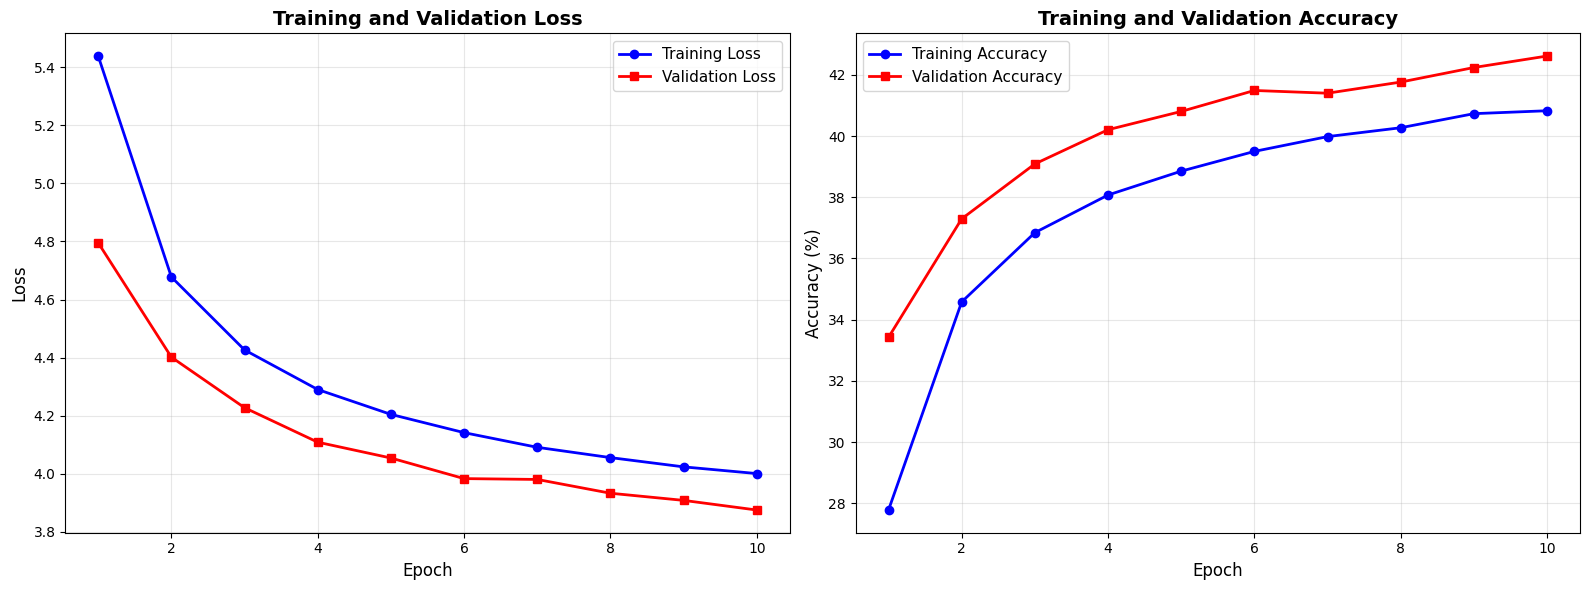


Final Training Loss: 4.0002  |  Final Training Accuracy: 40.83%
Final Validation Loss: 3.8746  |  Final Validation Accuracy: 42.61%
Best Validation Loss: 3.8746 (Epoch 10)
Best Validation Accuracy: 42.61% (Epoch 10)

✓ INFERENCE & EVALUATION COMPLETE!


In [31]:
"""
INFERENCE & EVALUATION - Matching Your Exact Training Code
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from collections import Counter
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import pandas as pd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ============================================================================
# MODELS - EXACTLY AS IN YOUR TRAINING
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, feature_size=2048, hidden_size=512, dropout=0.5):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(feature_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, features):
        x = self.fc(features)
        x = self.layer_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x  # Returns (batch_size, hidden_size)


class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.W_encoder = nn.Linear(encoder_dim, attention_dim)
        self.W_decoder = nn.Linear(decoder_dim, attention_dim)
        self.V = nn.Linear(attention_dim, 1)
    
    def forward(self, encoder_out, decoder_hidden, encoder_proj=None):
        if encoder_proj is None:
            encoder_proj = self.W_encoder(encoder_out)
        decoder_proj = self.W_decoder(decoder_hidden).unsqueeze(1)
        scores = self.V(torch.tanh(encoder_proj + decoder_proj)).squeeze(2)
        alpha = F.softmax(scores, dim=1)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return context, alpha


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.attention = BahdanauAttention(hidden_size, hidden_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + hidden_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size + hidden_size, vocab_size)
        self.gate = nn.Linear(hidden_size, hidden_size)
        self.init_h = nn.Linear(hidden_size, hidden_size)
        self.init_c = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.num_layers = num_layers
    
    def _init_hidden(self, encoder_out):
        # encoder_out: (batch_size, hidden_size) from training
        h0 = torch.tanh(self.init_h(encoder_out)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.tanh(self.init_c(encoder_out)).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return h0, c0
    
    def forward(self, encoder_out, captions, lengths):
        # This is used ONLY during training with teacher forcing
        batch_size = encoder_out.size(0)
        max_len = captions.size(1) - 1
        embeddings = self.embedding(captions[:, :-1])
        embeddings = self.dropout(embeddings)
        h, c = self._init_hidden(encoder_out)
        
        # Expand encoder_out for attention: (batch, hidden) -> (batch, 1, hidden)
        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)
        
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_out.device)
        for t in range(max_len):
            context, alpha = self.attention(encoder_out_expanded, h[-1], encoder_proj)
            gate = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate * context
            lstm_input = torch.cat([embeddings[:, t, :], gated_context], dim=1).unsqueeze(1)
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(torch.cat([lstm_out.squeeze(1), context], dim=1)))
            outputs[:, t, :] = output
        return outputs
    
    def sample(self, encoder_out, max_len=20):
        """Greedy decoding - for inference"""
        batch_size = encoder_out.size(0)
        sampled_ids = []
        
        # Initialize hidden states using encoder output
        h, c = self._init_hidden(encoder_out)
        
        # Expand encoder_out for attention: (batch, hidden) -> (batch, 1, hidden)
        encoder_out_expanded = encoder_out.unsqueeze(1)
        encoder_proj = self.attention.W_encoder(encoder_out_expanded)
        
        # Start with <start> token
        current_input = torch.ones(batch_size, dtype=torch.long).to(encoder_out.device)
        
        for t in range(max_len):
            # Embed current token
            embeddings = self.embedding(current_input)  # (batch_size, embed_size)
            
            # Get attention context
            context, alpha = self.attention(encoder_out_expanded, h[-1], encoder_proj)
            
            # Apply gating
            gate = torch.sigmoid(self.gate(h[-1]))
            gated_context = gate * context
            
            # LSTM input
            lstm_input = torch.cat([embeddings, gated_context], dim=1).unsqueeze(1)
            
            # LSTM forward
            lstm_out, (h, c) = self.lstm(lstm_input, (h, c))
            
            # Predict next token
            output = self.fc(self.dropout(torch.cat([lstm_out.squeeze(1), context], dim=1)))
            predicted = output.argmax(1)  # (batch_size,)
            
            sampled_ids.append(predicted.cpu().numpy())
            current_input = predicted
        
        return np.column_stack(sampled_ids)


# ============================================================================
# INFERENCE FUNCTIONS
# ============================================================================

def load_checkpoint(model_path, encoder, decoder, device):
    """Load model checkpoint"""
    checkpoint = torch.load(model_path, map_location=device)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    encoder.eval()
    decoder.eval()
    return encoder, decoder


def generate_caption(image_name, features_dict, encoder, decoder, idx2word, device):
    """Generate caption for single image"""
    if image_name not in features_dict:
        return "Image not found"
    
    features = torch.FloatTensor(features_dict[image_name]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Encode image features
        encoded = encoder(features)  # (1, hidden_size)
        
        # Generate caption
        sampled_ids = decoder.sample(encoded, max_len=20)
        sampled_ids = sampled_ids[0]  # Get first batch
    
    # Convert token IDs to words
    caption = []
    for word_id in sampled_ids:
        word = idx2word.get(int(word_id), '<unk>')
        if word == '<end>':
            break
        if word not in ['<start>', '<pad>']:
            caption.append(word)
    
    return ' '.join(caption)


# ============================================================================
# METRICS
# ============================================================================

def calculate_token_metrics(references_list, hypotheses_list):
    """Calculate token-level precision, recall, F1"""
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    count = 0
    
    for refs, hyp in zip(references_list, hypotheses_list):
        ref_tokens = refs[0]
        
        if len(hyp) == 0 or len(ref_tokens) == 0:
            continue
        
        ref_counter = Counter(ref_tokens)
        hyp_counter = Counter(hyp)
        
        overlap = sum((ref_counter & hyp_counter).values())
        
        p = overlap / len(hyp) if len(hyp) > 0 else 0
        r = overlap / len(ref_tokens) if len(ref_tokens) > 0 else 0
        f = 2 * p * r / (p + r) if (p + r) > 0 else 0
        
        total_precision += p
        total_recall += r
        total_f1 += f
        count += 1
    
    precision = total_precision / count if count > 0 else 0
    recall = total_recall / count if count > 0 else 0
    f1 = total_f1 / count if count > 0 else 0
    
    return precision, recall, f1


# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("INFERENCE & EVALUATION")
    print("="*70)
    
    # Load vocabulary
    print("\n[1] Loading vocabulary...")
    vocab_data = pickle.load(open('vocab.pkl', 'rb'))
    if isinstance(vocab_data, dict) and 'word2idx' in vocab_data:
        word2idx = vocab_data['word2idx']
        idx2word = vocab_data.get('idx2word', {v: k for k, v in word2idx.items()})
        vocab_size = len(word2idx)
    else:
        word2idx = vocab_data
        idx2word = {v: k for k, v in word2idx.items()}
        vocab_size = len(vocab_data)
    print(f"✓ Vocab size: {vocab_size}")
    
    # Load features
    print("[2] Loading image features...")
    with open('flickr30k_features.pkl', 'rb') as f:
        features_dict = pickle.load(f)
    print(f"✓ Loaded {len(features_dict)} images")
    
    # Load captions
    print("[3] Loading captions...")
    with open('captions.pkl', 'rb') as f:
        caption_data = pickle.load(f)
    if 'preprocessed_captions' in caption_data:
        all_captions = caption_data['preprocessed_captions']
    elif 'image_to_processed' in caption_data:
        image_to_captions = caption_data['image_to_processed']
    else:
        image_to_captions = {img: [c] for img, c in enumerate(list(caption_data.values())[0])}
    print(f"✓ Loaded captions")
    
    # Initialize models
    print("[4] Initializing models...")
    encoder = Encoder(feature_size=2048, hidden_size=512, dropout=0.5).to(DEVICE)
    decoder = Decoder(vocab_size=vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.5).to(DEVICE)
    
    # Load checkpoint
    print("[5] Loading checkpoint...")
    encoder, decoder = load_checkpoint('best_model.pth', encoder, decoder, DEVICE)
    print("✓ Best model loaded")
    
    # Load training history
    print("[5.5] Loading training history...")
    try:
        with open('training_history.json', 'r') as f:
            history = json.load(f)
        train_losses = history['train_loss']
        val_losses = history['val_loss']
        train_accuracies = history['train_acc']
        val_accuracies = history['val_acc']
        print("✓ Training history loaded")
        has_history = True
    except:
        print("⚠ Training history not found, skipping loss curves")
        has_history = False
    
    # Generate captions
    print("\n[6] Generating captions...")
    test_images = list(features_dict.keys())[:500]
    generated_captions = {}
    reference_captions = {}
    
    for img_name in tqdm(test_images, desc="Generating"):
        if img_name in features_dict:
            generated = generate_caption(img_name, features_dict, encoder, decoder, idx2word, DEVICE)
            generated_captions[img_name] = generated.split()
            
            if img_name in image_to_captions:
                refs = []
                for cap in image_to_captions[img_name]:
                    cap_clean = cap.replace('<start>', '').replace('<end>', '').strip()
                    refs.append(cap_clean.split())
                reference_captions[img_name] = refs
    
    print(f"✓ Generated {len(generated_captions)} captions")
    
    # Display sample captions
    print("\n" + "="*70)
    print("SAMPLE GENERATED CAPTIONS")
    print("="*70)
    
    sample_count = 0
    for img_name in list(generated_captions.keys())[:10]:
        if img_name in reference_captions:
            gt = ' '.join(reference_captions[img_name][0])
            gen = ' '.join(generated_captions[img_name])
            
            print(f"\n[Sample {sample_count + 1}] Image: {img_name}")
            print(f"  Ground Truth: {gt}")
            print(f"  Generated:   {gen}")
            sample_count += 1
    
    # Calculate BLEU scores
    print("\n[7] Calculating metrics...")
    references_list = [reference_captions[img] for img in generated_captions.keys() if img in reference_captions]
    hypotheses_list = [generated_captions[img] for img in generated_captions.keys() if img in reference_captions]
    
    smoother = SmoothingFunction().method1
    
    bleu1 = corpus_bleu(references_list, hypotheses_list, weights=(1.0, 0, 0, 0), smoothing_function=smoother)
    bleu2 = corpus_bleu(references_list, hypotheses_list, weights=(0.5, 0.5, 0, 0), smoothing_function=smoother)
    bleu3 = corpus_bleu(references_list, hypotheses_list, weights=(1/3, 1/3, 1/3, 0), smoothing_function=smoother)
    bleu4 = corpus_bleu(references_list, hypotheses_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother)
    
    precision, recall, f1 = calculate_token_metrics(references_list, hypotheses_list)
    
    # Print results
    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)
    print(f"\nBLEU Scores:")
    print(f"  - BLEU-1: {bleu1:.4f}")
    print(f"  - BLEU-2: {bleu2:.4f}")
    print(f"  - BLEU-3: {bleu3:.4f}")
    print(f"  - BLEU-4: {bleu4:.4f}")
    print(f"\nToken-Level Metrics:")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1-Score: {f1:.4f}")
    
    # Save metrics
    metrics_summary = {
        'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'Precision', 'Recall', 'F1-Score'],
        'Score': [bleu1, bleu2, bleu3, bleu4, precision, recall, f1]
    }
    
    metrics_df = pd.DataFrame(metrics_summary)
    metrics_df.to_csv('evaluation_metrics.csv', index=False)
    print("\n✓ Metrics saved to 'evaluation_metrics.csv'")
    
    # Plot loss and accuracy curves
    if has_history:
        print("\n[8] Plotting loss and accuracy curves...")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Loss curve
        ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-o', label='Training Loss', linewidth=2)
        ax1.plot(range(1, len(val_losses) + 1), val_losses, 'r-s', label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Accuracy curve
        ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-o', label='Training Accuracy', linewidth=2)
        ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r-s', label='Validation Accuracy', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('loss_accuracy_curve.png', dpi=150, bbox_inches='tight')
        print("✓ Loss & accuracy curves saved as 'loss_accuracy_curve.png'")
        plt.show()
        
        print(f"\nFinal Training Loss: {train_losses[-1]:.4f}  |  Final Training Accuracy: {train_accuracies[-1]:.2f}%")
        print(f"Final Validation Loss: {val_losses[-1]:.4f}  |  Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
        print(f"Best Validation Loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses)) + 1})")
        print(f"Best Validation Accuracy: {max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies)) + 1})")
    
    print("\n" + "="*70)
    print("✓ INFERENCE & EVALUATION COMPLETE!")
    print("="*70)